<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_DC_ZTM/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Setup

import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [27]:
# Download the tf_flowers dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [28]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


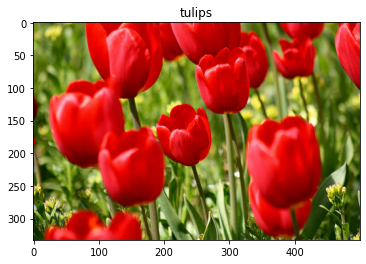

In [29]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Keras Preprocessed layers

In [30]:
# Resize and rescale
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

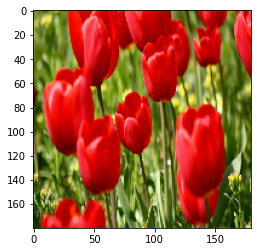

In [31]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [32]:
print("Min and max pixel values: ", result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


# Create preprocessing layers for data augmentation

In [33]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

In [35]:
image

<tf.Tensor: shape=(1, 333, 500, 3), dtype=uint8, numpy=
array([[[[ 93, 122,  30],
         [ 90, 118,  31],
         [ 88, 118,  28],
         ...,
         [247,  77,  78],
         [253,  87,  87],
         [255,  76,  75]],

        [[ 98, 125,  30],
         [ 95, 124,  32],
         [ 96, 125,  32],
         ...,
         [247,  81,  83],
         [250,  86,  84],
         [252,  71,  64]],

        [[ 98, 126,  26],
         [101, 128,  31],
         [106, 132,  33],
         ...,
         [254,  81,  85],
         [254,  79,  76],
         [252,  55,  47]],

        ...,

        [[ 35,  51,   6],
         [ 21,  49,   0],
         [ 30,  57,   6],
         ...,
         [224, 239,  78],
         [192, 208,  50],
         [ 88,  54,  53]],

        [[ 65,  73,  32],
         [ 20,  46,   0],
         [ 22,  48,   0],
         ...,
         [230, 236,  74],
         [230, 246,  62],
         [ 88,  57,  36]],

        [[ 95,  97,  60],
         [ 15,  41,   0],
         [ 23,  51

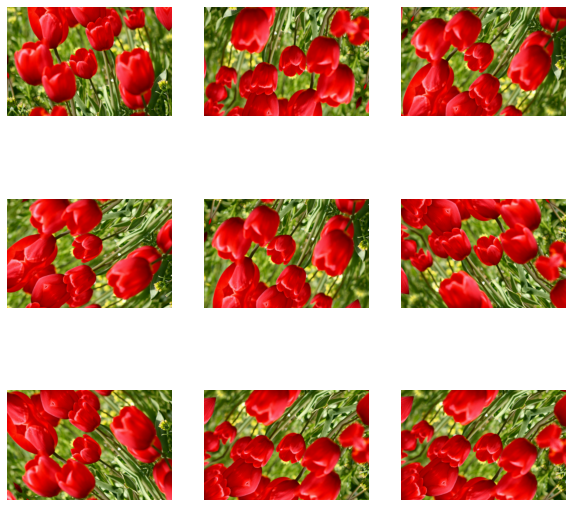

In [36]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

In [37]:
# Using the preprocessing layer in the model
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPool2D()
])

In [38]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescall all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x),y),
              num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
      ds = ds.map(lambda x, y: (data_augmentation(x, training=True),y),
                  num_parallel_calls=AUTOTUNE)
      
    # USe buffered prefecting on all datasets
    return ds.prefetch(buffer_size = AUTOTUNE)

In [39]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [42]:
# Train a model
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
epochs=5
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 103s 1s/step - loss: 1.2581 - accuracy: 0.4707
Epoch 2/5
92/92 [==============================] - 98s 1s/step - loss: 1.0276 - accuracy: 0.5814
Epoch 3/5
92/92 [==============================] - 98s 1s/step - loss: 0.9418 - accuracy: 0.6165
Epoch 4/5
92/92 [==============================] - 99s 1s/step - loss: 0.9011 - accuracy: 0.6393
Epoch 5/5
92/92 [==============================] - 97s 1s/step - loss: 0.8462 - accuracy: 0.6557


In [49]:
model.evaluate(train_ds)


92/92 [==============================] - 36s 375ms/step - loss: 0.8279 - accuracy: 0.6693


[0.8278960585594177, 0.6692779064178467]

In [51]:
model.evaluate(test_ds)

ValueError: ignored

## Custom data augmentation

In [53]:
def random_invert_img(x, p=0.5):
  if tf.random.uniform([]) <p:
    x = (255-x)
  else:
      x
  return x 

In [55]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

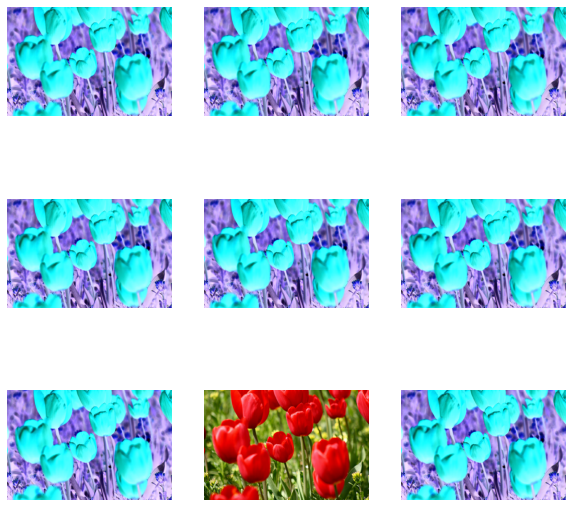

In [62]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis('off')

In [63]:
# Implement subclassing
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

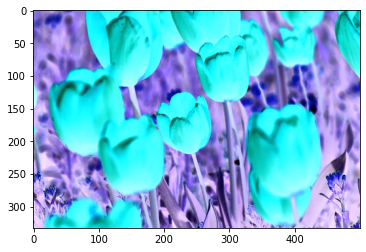

In [66]:
_ = plt.imshow(RandomInvert()(image)[0])

In [68]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]','train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

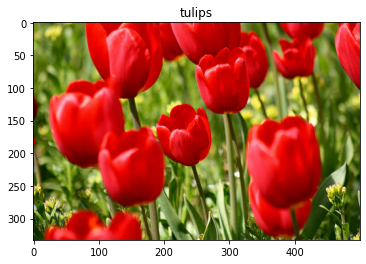

In [71]:
image, label = next(iter(train_ds),10)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [72]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

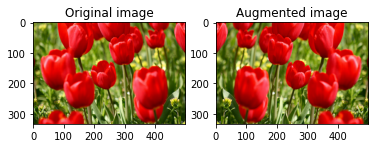

In [73]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

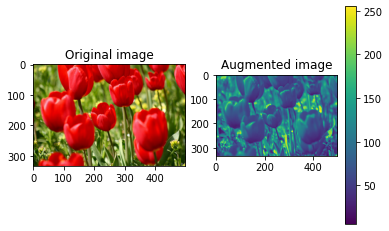

In [74]:
# Gray scale image
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

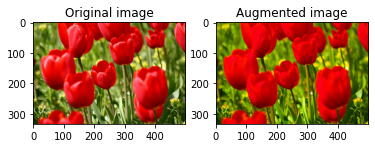

In [75]:
# Saturate image
saturated = tf.image.adjust_saturation(image,3)
visualize(image, saturated)

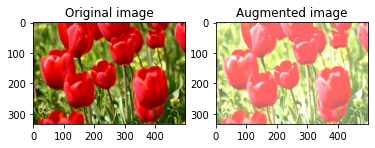

In [76]:
# Change brightness
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

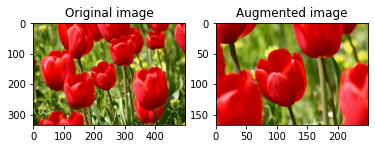

In [77]:
# Crop image
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

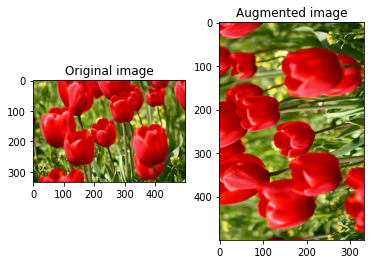

In [78]:
# Rotation
rotated = tf.image.rot90(image)
visualize(image, rotated)

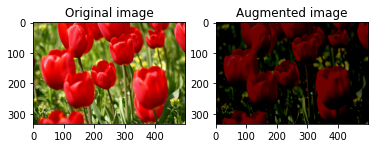

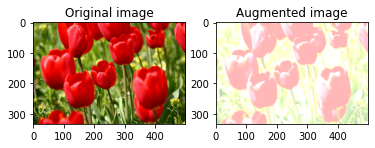

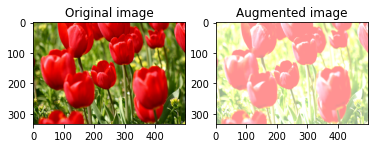

In [79]:
# Randomly change brightness
for i in range(3):
  seed = (i,0) # seed is tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

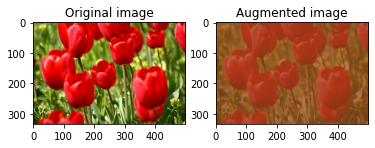

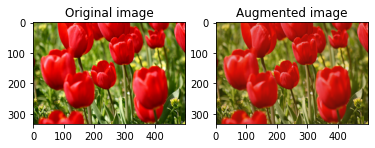

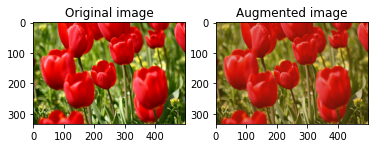

In [80]:
# randomly change image contrast
for i in range(3):
  seed = (i, 0)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

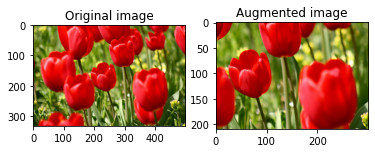

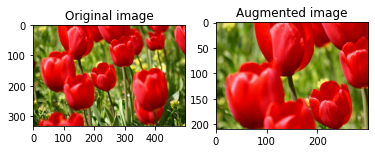

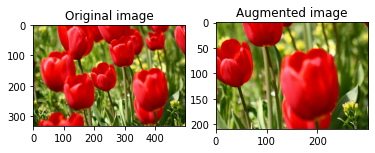

In [81]:
# Randomly crop image
for i in range(3):
  seed=(i,0)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210,300,3], seed=seed)
  visualize(image, stateless_random_crop)

In [89]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [90]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [91]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [92]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

# Augment the training set option 1

In [93]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [94]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [95]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Augment the training set option2

In [96]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [97]:
# Create wrapper function for updating seeds
def f(x,y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x,y), seed)
  return image, label

In [98]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [99]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [100]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)